In [1]:
# gpu number setting
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '1' ## gpu 번호 셋팅 윤건 :0, 기준 : 1, 준형 :2,

# Gpu growth setting
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


# tensorflow & keras version check
print('tensorflow version : ' , tf.__version__)
print('keras version : ' , tf.keras.__version__)

# tensorflow gpu available check 
print('GPU available ? : ', tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

tensorflow version :  2.3.1
keras version :  2.4.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available ? :  True


In [2]:
import pandas as pd
import numpy as np
import pickle
import tqdm
import random
import time

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from deepctr.models import *
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [4]:
with open('../../Data/movie_201118_table_6.pickle', 'rb') as f:
    data = pickle.load(f)

In [6]:
data = data[['sa_id', 'album_id', 'label']]

In [8]:
sparse_features = ['sa_id', 'album_id',
#                    'buy_seg'
                  ]
dense_features = ['release_date', 'run_time', 'movie_meta_price', 'i30_meta_price', 'buy_tot',
                  'amt_1_4', 'amt_2_4', 'amt_3_4', 'amt_4_4']
target = ['label']

In [9]:
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
    
mms = MinMaxScaler(feature_range=(0, 1))
# data[dense_features] = mms.fit_transform(data[dense_features])

/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4)
                           for i,feat in enumerate(sparse_features)]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [11]:
train, test = train_test_split(data, test_size=0.2, random_state=2020)
train_model_input = {name:train[name] for name in feature_names}
test_model_input = {name:test[name] for name in feature_names}

In [14]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [16]:
history = model.fit(train_model_input, train[target].values,
                    batch_size=2**16, epochs=200, verbose=1, validation_split=0.2,
                   callbacks=[callback])

Epoch 1/200


/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


153/153 [==============================] - 4s 23ms/step - loss: 0.4334 - binary_crossentropy: 0.4312 - val_loss: 0.3078 - val_binary_crossentropy: 0.3030
Epoch 2/200
153/153 [==============================] - 3s 20ms/step - loss: 0.2970 - binary_crossentropy: 0.2897 - val_loss: 0.2988 - val_binary_crossentropy: 0.2895
Epoch 3/200
153/153 [==============================] - 3s 19ms/step - loss: 0.2733 - binary_crossentropy: 0.2617 - val_loss: 0.2958 - val_binary_crossentropy: 0.2821
Epoch 4/200
153/153 [==============================] - 3s 19ms/step - loss: 0.2540 - binary_crossentropy: 0.2391 - val_loss: 0.3041 - val_binary_crossentropy: 0.2881
Epoch 5/200
153/153 [==============================] - 3s 19ms/step - loss: 0.2403 - binary_crossentropy: 0.2239 - val_loss: 0.3122 - val_binary_crossentropy: 0.2950
Epoch 6/200
153/153 [==============================] - 3s 19ms/step - loss: 0.2299 - binary_crossentropy: 0.2124 - val_loss: 0.3171 - val_binary_crossentropy: 0.2989
Epoch 7/200
153/

In [17]:
pred_ans = model.predict(test_model_input, batch_size=2**16)
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

test LogLoss 0.3096
test AUC 0.9451


In [14]:
import matplotlib.pyplot as plt

(array([1162466.,  107607.,   77436.,   69661.,   71367.,   80663.,
         100856.,  139672.,  236865., 1067861.]),
 array([4.7636490e-06, 1.0000041e-01, 1.9999607e-01, 2.9999170e-01,
        3.9998737e-01, 4.9998301e-01, 5.9997869e-01, 6.9997430e-01,
        7.9996997e-01, 8.9996558e-01, 9.9996126e-01], dtype=float32),
 <a list of 10 Patch objects>)

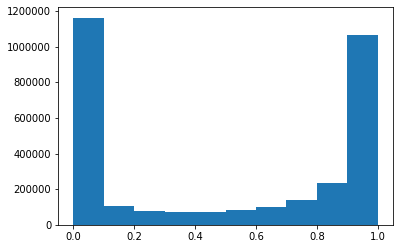

In [15]:
plt.hist(pred_ans)

In [1]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'plt' is not defined

In [16]:
model.save(filepath='./model/201120/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model/201120/assets
